In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy import units as u
from astropy.coordinates import (
    CartesianRepresentation, CylindricalRepresentation,
    UnitSphericalRepresentation)

from screens.screen import Source, Screen1D, Telescope
from screens.fields import phasor

In [2]:
def axis_extent(x):
    x = x.ravel().value
    dx = x[1]-x[0]
    return x[0]-0.5*dx, x[-1]+0.5*dx

In [3]:
d_p = 0.5 * u.kpc
d_s = 0.25 * u.kpc

In [4]:
pulsar_vel = CartesianRepresentation(-300., 0., 0., unit=u.km/u.s)

pulsar = Source(vel=pulsar_vel)

print(pulsar)

<Source
    pos=(0., 0., 0.) AU,
    vel=(-300., 0., 0.) km / s,
    magnification=1.0>


In [5]:
scr1_normal = CylindricalRepresentation(1., 67.*u.deg, 0.).to_cartesian()
scr1_pos = np.array([-1., -0.25, 0., 0.5]) << u.au
scr1_vel = 0. * u.km/u.s
scr1_magnification = np.array([-0.1 - 0.1j,
                                0.5 - 0.2j,
                                0.8,
                                0.2 + 0.1j])

scr1 = Screen1D(normal=scr1_normal, p=scr1_pos, v=scr1_vel,
                magnification=scr1_magnification)

print(scr1)

<Screen1D
    normal=(0.39073113, 0.92050485, 0.) ,
    p=[-1.   -0.25  0.    0.5 ] AU,
    v=0.0 km / s,
    magnification=[-0.1-0.1j  0.5-0.2j  0.8+0.j   0.2+0.1j]>


In [6]:
telescope = Telescope()

print(telescope)

<Telescope
    pos=(0., 0., 0.) AU,
    vel=(0., 0., 0.) km / s,
    magnification=1.0>


In [7]:
telescope.observe(source=pulsar, distance=d_p)

<Telescope
    pos=(0., 0., 0.) AU,
    vel=(0., 0., 0.) km / s,
    magnification=1.0,
    source=<Source
        pos=(0., 0., 0.) AU,
        vel=(-300., 0., 0.) km / s,
        magnification=1.0>,
    distance=0.5 kpc>

In [8]:
obs_scr1_pulsar = scr1.observe(source=pulsar, distance=d_p-d_s)
obs1 = telescope.observe(source=obs_scr1_pulsar, distance=d_s)

print(obs1)

<Telescope
    pos=(0., 0., 0.) AU,
    vel=(0., 0., 0.) km / s,
    magnification=1.0,
    source=<Screen1D
        normal=(0.39073113, 0.92050485, 0.) ,
        p=[-1.   -0.25  0.    0.5 ] AU,
        v=0.0 km / s,
        magnification=[-0.1-0.1j  0.5-0.2j  0.8+0.j   0.2+0.1j],
        source=<Source
            pos=(0., 0., 0.) AU,
            vel=(-300., 0., 0.) km / s,
            magnification=1.0>,
        distance=0.25 kpc>,
    distance=0.25 kpc>


In [9]:
obs1.brightness

array([-0.1-0.1j,  0.5-0.2j,  0.8+0.j ,  0.2+0.1j])

In [10]:
obs1.tau

<Quantity [9.67697385, 0.60481087, 0.        , 2.41924346] us>

In [11]:
obs1.taudot

<Quantity [-7.58251751e-06, -1.89562938e-06,  0.00000000e+00,
            3.79125875e-06] us / s>

In [12]:
t = np.linspace(0, 90*u.min, 180)[:, np.newaxis]
f = np.linspace(315*u.MHz, 317*u.MHz, 200)

In [13]:
tau0 = obs1.tau[:, np.newaxis, np.newaxis]
taudot = obs1.taudot[:, np.newaxis, np.newaxis]
tau_t = tau0 + taudot * t

In [14]:
ph = phasor(f, tau_t)
brightness = obs1.brightness[:, np.newaxis, np.newaxis]
dynwave = ph * brightness

dynspec = np.abs(dynwave.sum(axis=0))**2

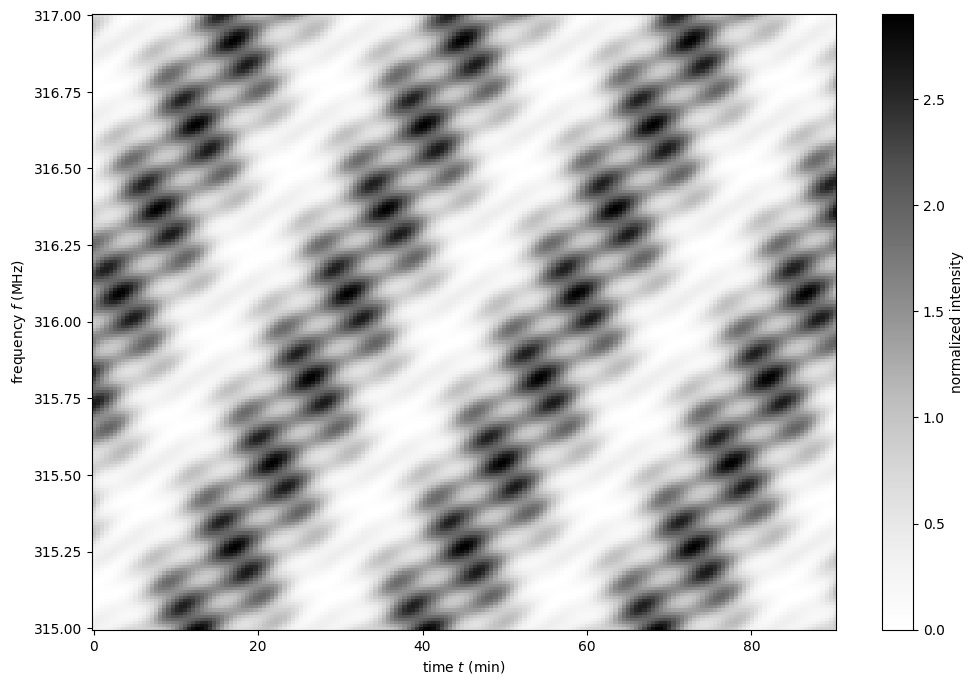

In [15]:
plt.figure(figsize=(12., 8.))

plt.imshow(dynspec.T,
           origin='lower', aspect='auto', interpolation='none',
           cmap='Greys', extent=axis_extent(t) + axis_extent(f), vmin=0.)
plt.xlabel(rf"time $t$ ({t.unit.to_string('latex')})")
plt.ylabel(rf"frequency $f$ ({f.unit.to_string('latex')})")

cbar = plt.colorbar()
cbar.set_label('normalized intensity')

In [16]:
conjspec = np.fft.fft2(dynspec)
conjspec /= conjspec[0, 0]
conjspec = np.fft.fftshift(conjspec)

tau = np.fft.fftshift(np.fft.fftfreq(f.size, f[1]-f[0])).to(u.us)
fd = np.fft.fftshift(np.fft.fftfreq(t.size, t[1]-t[0])).to(u.mHz)

secspec = np.abs(conjspec)**2

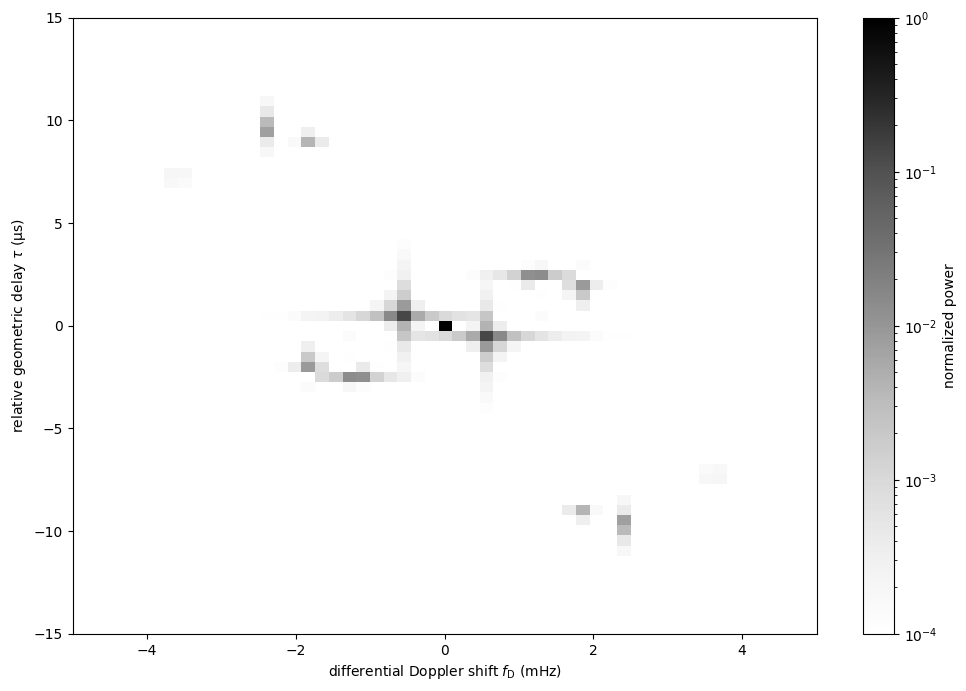

In [17]:
plt.figure(figsize=(12., 8.))

plt.imshow(secspec.T,
           origin='lower', aspect='auto', interpolation='none',
           cmap='Greys', extent=axis_extent(fd) + axis_extent(tau),
           norm=LogNorm(vmin=1.e-4, vmax=1.))
plt.xlim(-5., 5.)
plt.ylim(-15., 15.)
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ "
           rf"({fd.unit.to_string('latex')})")
plt.ylabel(r"relative geometric delay $\tau$ "
           rf"({tau.unit.to_string('latex')})")

cbar = plt.colorbar()
cbar.set_label('normalized power')

plt.show()

In [18]:
def unit_vector(c):
    return c.represent_as(UnitSphericalRepresentation).to_cartesian()

ZHAT = CartesianRepresentation(0., 0., 1., unit=u.one)

def plot_screen(ax, s, d, color='black', **kwargs):
    d = d.to_value(u.kpc)
    x = np.array(ax.get_xlim3d())
    y = np.array(ax.get_ylim3d())[:, np.newaxis]
    ax.plot_surface([[-2.1, 2.1]]*2, [[-2.1]*2, [2.1]*2], d*np.ones((2, 2)),
                    alpha=0.1, color=color)
    x = ax.get_xticks()
    y = ax.get_yticks()[:, np.newaxis]
    ax.plot_wireframe(x, y, np.broadcast_to(d, (x+y).shape),
                    alpha=0.2, color=color)
    spos = s.normal * s.p if isinstance(s, Screen1D) else s.pos
    ax.scatter(spos.x.to_value(u.AU), spos.y.to_value(u.AU), d,
               c=color, marker='+')
    if spos.shape:
        for pos in spos:
            zo = np.arange(2)
            ax.plot(pos.x.to_value(u.AU)*zo, pos.y.to_value(u.AU)*zo,
                    np.ones(2) * d, c=color, linestyle=':')
            upos = pos + (ZHAT.cross(unit_vector(pos)) * ([-1.5, 1.5] * u.AU))
            ax.plot(upos.x.to_value(u.AU), upos.y.to_value(u.AU),
                    np.ones(2) * d, c=color, linestyle='-')
    elif s.vel.norm() != 0:
        dp = s.vel * 5 * u.day
        ax.quiver(spos.x.to_value(u.AU), spos.y.to_value(u.AU), d,
                dp.x.to_value(u.AU), dp.y.to_value(u.AU), np.zeros(1),
                arrow_length_ratio=0.05)

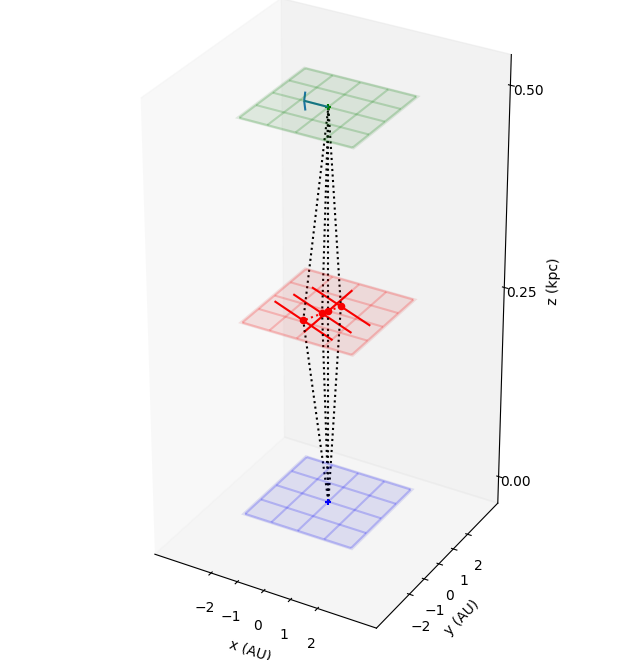

In [19]:
plt.figure(figsize=(8., 12.))
ax = plt.subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 2))
# ax.set_axis_off()
ax.grid(False)
ax.set_xlim3d(-4, 4)
ax.set_ylim3d(-4, 4)
ax.set_xticks([-2, -1, 0, 1., 2])
ax.set_yticks([-2, -1, 0, 1., 2])
ax.set_zticks([0, d_s.value, d_p.value])
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')
ax.set_zlabel('z (kpc)', labelpad=12)
plot_screen(ax, telescope, 0*u.kpc, color='blue')
plot_screen(ax, scr1, d_s, color='red')
plot_screen(ax, pulsar, d_p, color='green')

path_shape = obs1.tau.shape
tpos = obs1.pos
scat1 = obs1.source.pos
ppos = obs1.source.source.pos
x = np.vstack(
    [np.broadcast_to(getattr(pos, 'x').to_value(u.AU), path_shape).ravel()
    for pos in (tpos, scat1, ppos)])
y = np.vstack(
    [np.broadcast_to(getattr(pos, 'y').to_value(u.AU), path_shape).ravel()
    for pos in (tpos, scat1, ppos)])
z = np.vstack(
    [np.broadcast_to(d, path_shape).ravel()
    for d in (0., d_s.value, d_p.value)])
for _x, _y, _z in zip(x.T, y.T, z.T):
    ax.plot(_x, _y, _z, color='black', linestyle=':')
    ax.scatter(_x[1], _y[1], _z[1], marker='o', color='red')